# Healthcare Decoder Transformer - Compact Version

A streamlined implementation of a decoder-only transformer for healthcare diagnosis prediction using Keras best practices.

## Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, losses, callbacks
import matplotlib.pyplot as plt

# Load and prepare data
from fn_data_prep import create_sequences

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [2]:
# Load healthcare claims data
claims = pd.read_csv('../data/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv')

# Prepare diagnosis sequences
claims_clean = claims[['DESYNPUF_ID', 'CLM_ADMSN_DT', 'ICD9_DGNS_CD_1']] \
    .rename(columns={'DESYNPUF_ID': 'patient', 'CLM_ADMSN_DT': 'date', 'ICD9_DGNS_CD_1': 'dx'}) \
    .sort_values(['patient', 'date'])

dx_sequences = create_sequences(claims_clean)
dx_sequences = [seq for seq in dx_sequences if len(seq.split()) > 4]

print(f"Total sequences: {len(dx_sequences)}")
print(f"Example sequence: {dx_sequences[0]}")
print(f"Unique diagnoses: {claims_clean['dx'].nunique()}")

Total sequences: 1782
Example sequence: 6826 485 4589 7211 49122
Unique diagnoses: 2740


## Model Configuration

In [3]:
# Model hyperparameters - optimized for healthcare sequences
CONFIG = {
    'vocab_size': claims_clean['dx'].nunique(),
    'max_len': 10,          # Increased for better context
    'embed_dim': 128,       # Richer embeddings
    'num_heads': 8,         # Multi-head attention
    'ff_dim': 512,          # Feed-forward dimension
    'num_layers': 4,        # Multiple transformer blocks
    'dropout_rate': 0.1,    # Regularization
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 1e-4
}

print("Model Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Model Configuration:
  vocab_size: 2740
  max_len: 10
  embed_dim: 128
  num_heads: 8
  ff_dim: 512
  num_layers: 4
  dropout_rate: 0.1
  batch_size: 32
  epochs: 50
  learning_rate: 0.0001


## Data Pipeline

In [4]:
# Create text vectorization layer
vectorizer = layers.TextVectorization(
    max_tokens=CONFIG['vocab_size'],
    output_sequence_length=CONFIG['max_len'] + 1,
    output_mode='int'
)

# Create dataset and adapt vectorizer
text_ds = tf.data.Dataset.from_tensor_slices(dx_sequences)
vectorizer.adapt(text_ds.batch(CONFIG['batch_size']))
vocab = vectorizer.get_vocabulary()

def prepare_sequences(texts):
    """Prepare input-target pairs for autoregressive training."""
    texts = tf.expand_dims(texts, -1)
    tokenized = vectorizer(texts)
    inputs = tokenized[:, :-1]  # All tokens except last
    targets = tokenized[:, 1:]  # All tokens except first (shifted)
    return inputs, targets

# Create training dataset
train_ds = text_ds.batch(CONFIG['batch_size']) \
    .map(prepare_sequences, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

print(f"Vocabulary size: {len(vocab)}")
print(f"Training batches: {len(list(train_ds))}")

Vocabulary size: 1356
Training batches: 56


## Custom Layers (Best Practices)

In [6]:
@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    """Combines token and positional embeddings."""
    
    def __init__(self, vocab_size, embed_dim, max_len, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_len = max_len
        
    def build(self, input_shape):
        self.token_embedding = layers.Embedding(self.vocab_size, self.embed_dim)
        self.position_embedding = layers.Embedding(self.max_len, self.embed_dim)
        super().build(input_shape)
        
    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        positions = tf.range(seq_len)
        position_embeds = self.position_embedding(positions)
        token_embeds = self.token_embedding(inputs)
        return token_embeds + position_embeds
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'max_len': self.max_len
        })
        return config


@keras.utils.register_keras_serializable()
class DecoderBlock(layers.Layer):
    """Transformer decoder block with causal masking."""
    
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        # Multi-head self-attention
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim,
            dropout=self.dropout_rate
        )
        
        # Feed-forward network
        self.ffn = keras.Sequential([
            layers.Dense(self.ff_dim, activation='relu'),
            layers.Dense(self.embed_dim)
        ])
        
        # Layer normalization and dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(self.dropout_rate)
        self.dropout2 = layers.Dropout(self.dropout_rate)
        
        super().build(input_shape)
        
    def call(self, inputs, training=None):
        seq_len = tf.shape(inputs)[1]
        
        # Create causal mask
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        causal_mask = tf.cast(causal_mask, tf.bool)
        
        # Self-attention with causal masking
        attn_output = self.attention(
            inputs, inputs, attention_mask=causal_mask, training=training
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

## Model Architecture

In [7]:
def create_decoder_transformer(config):
    """Create a decoder-only transformer model."""
    
    # Input layer
    inputs = layers.Input(shape=(config['max_len'],), dtype=tf.int32, name='diagnosis_tokens')
    
    # Positional embeddings
    x = PositionalEmbedding(
        vocab_size=config['vocab_size'],
        embed_dim=config['embed_dim'],
        max_len=config['max_len']
    )(inputs)
    
    # Stack decoder blocks
    for i in range(config['num_layers']):
        x = DecoderBlock(
            embed_dim=config['embed_dim'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            dropout_rate=config['dropout_rate']
        )(x)
    
    # Output projection
    outputs = layers.Dense(config['vocab_size'], name='vocab_projection')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='healthcare_decoder_transformer')
    
    return model

# Create the model
model = create_decoder_transformer(CONFIG)
model.summary()

Model: "healthcare_decoder_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ diagnosis_tokens (InputLayer)   │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, 10, 128)        │       352,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block (DecoderBlock)    │ (None, 10, 128)        │       659,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_1 (DecoderBlock)  │ (None, 10, 128)        │       659,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_2 (DecoderBlock)  │ (None, 10, 128)        │       659,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_3 (DecoderBlock)  │ (None, 10, 128)        │       659,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vocab_projection (Dense)        │ (None, 10, 2740)       │       353,460 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,344,308 (12.76 MB)

 Trainable params: 3,344,308 (12.76 MB)

 Non-trainable params: 0 (0.00 B)

## Training Setup

In [8]:
# Compile model with best practices
model.compile(
    optimizer=optimizers.AdamW(
        learning_rate=CONFIG['learning_rate'],
        weight_decay=1e-4
    ),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for better training
training_callbacks = [
    callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    callbacks.ModelCheckpoint(
        '../models/healthcare_transformer_best.keras',
        monitor='loss',
        save_best_only=True
    )
]

## Training

Starting training...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3983 - loss: 6.7311 - learning_rate: 1.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3983 - loss: 6.7311 - learning_rate: 1.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5044 - loss: 5.3586 - learning_rate: 1.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5044 - loss: 5.3586 - learning_rate: 1.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5044 - loss: 4.5808 - learning_rate: 1.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5044 - loss: 4.5808 - learning_rate: 1.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5044 - loss: 3.9926 - learning_rate: 1.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5044 - loss: 3.9926 - learning_rate: 1.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5044 - l

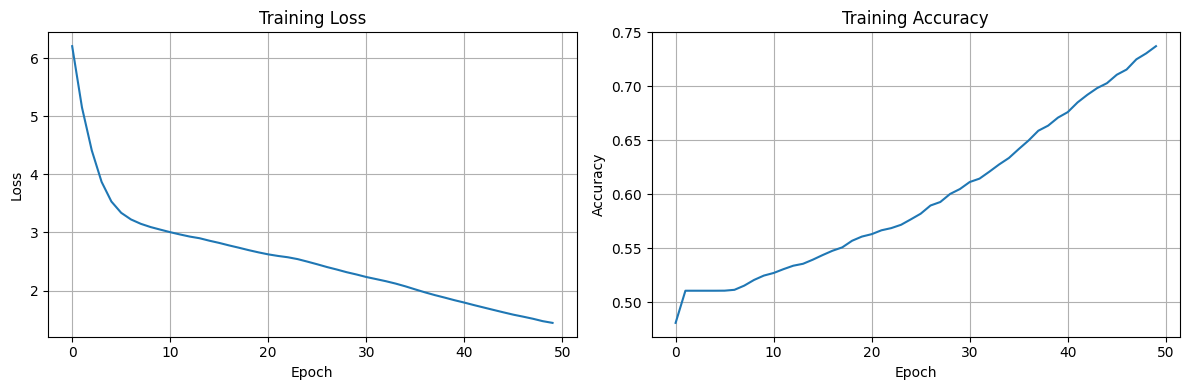

In [9]:
# Train the model
print("Starting training...")
history = model.fit(
    train_ds,
    epochs=CONFIG['epochs'],
    callbacks=training_callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Saving & End-to-End Pipeline

In [ ]:
def create_inference_model(trained_model, vectorizer):
    """Create end-to-end model for inference."""
    
    # Text input
    text_input = layers.Input(shape=(), dtype=tf.string, name='diagnosis_sequence')
    
    # Vectorize and prepare for transformer
    vectorized = vectorizer(text_input)
    transformer_input = vectorized[:, :-1]  # Remove last token for input
    
    # Apply trained transformer
    predictions = trained_model(transformer_input)
    
    # Create inference model
    inference_model = models.Model(
        inputs=text_input,
        outputs=predictions,
        name='healthcare_transformer_inference'
    )
    
    return inference_model

# Create inference model
inference_model = create_inference_model(model, vectorizer)

# Save models
model.save('../models/healthcare_transformer_compact.keras')
inference_model.save('../models/healthcare_transformer_inference.keras')

print(" Models saved successfully!")
print(f"Model parameters: {model.count_params():,}")

✅ Models saved successfully!
📊 Model parameters: 3,344,308


## Inference & Testing

In [11]:
def predict_next_diagnosis(sequence, model, vectorizer, vocab, top_k=5):
    """Predict next diagnosis codes for a given sequence."""
    
    # Vectorize input
    vectorized = vectorizer([sequence])
    input_tokens = vectorized[0, :-1]  # Remove last token
    input_tokens = tf.expand_dims(input_tokens, 0)
    
    # Get predictions
    logits = model(input_tokens, training=False)
    
    # Get probabilities for next token position
    seq_len = len(sequence.split())
    if seq_len >= logits.shape[1]:
        seq_len = logits.shape[1] - 1
        
    next_token_logits = logits[0, seq_len]
    probabilities = tf.nn.softmax(next_token_logits)
    
    # Get top-k predictions
    top_indices = tf.nn.top_k(probabilities, k=top_k).indices.numpy()
    top_probs = tf.nn.top_k(probabilities, k=top_k).values.numpy()
    
    # Convert to diagnosis codes
    predictions = []
    for idx, prob in zip(top_indices, top_probs):
        if idx < len(vocab):
            code = vocab[idx]
            if code and code not in ['', '[UNK]']:
                predictions.append((code, float(prob)))
    
    return predictions

# Test predictions
test_sequences = ["6826 485", "1970 4589", "250"]

print("Healthcare Diagnosis Predictions")
print("=" * 50)

for seq in test_sequences:
    predictions = predict_next_diagnosis(seq, model, vectorizer, vocab, top_k=3)
    print(f"\nInput: '{seq}'")
    print("Top 3 next diagnosis predictions:")
    for i, (code, prob) in enumerate(predictions, 1):
        print(f"  {i}. {code}: {prob:.4f}")

print("\n Compact healthcare transformer ready for deployment!")

Healthcare Diagnosis Predictions

Input: '6826 485'
Top 3 next diagnosis predictions:
  1. 486: 0.0001
  2. 29570: 0.0001

Input: '1970 4589'
Top 3 next diagnosis predictions:
  1. 29570: 0.0001
  2. 486: 0.0001

Input: '250'
Top 3 next diagnosis predictions:
  1. 29570: 0.0001
  2. 0389: 0.0001

 Compact healthcare transformer ready for deployment!
